# AOC Stats Rainclouds N-back

## Setup

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde

from stats_helpers import (
    iqr_outlier_filter,
    mixedlm_pairwise_contrasts,
    p_to_signif
)

from plotting_helpers import (
    add_stat_brackets,
)

### Parameters

In [1]:
# Colors
pal = ["#93B8C4", "#82AD82", "#D998A2"]  # AOC pastels

# Plot Appearance
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "savefig.transparent": False,
    "savefig.facecolor": "white",
    "savefig.bbox": "tight",
    "ps.fonttype": 42,
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "mathtext.default": "regular",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "figure.edgecolor": "white",
    "axes.edgecolor": "white",
})

# Force set figure to white
sns.set_style("white")  # clean white background, no grey panel

# Display plots in high resolution
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")

### Read Data

In [2]:
# I/O Dirs
input_csv  = "/Volumes/g_psyplafor_methlab$/Students/Arne/AOC/data/features/merged_data_nback.csv"
output_dir = "/Volumes/g_psyplafor_methlab$/Students/Arne/AOC/figures/stats/rainclouds"

# Load Data
dat = pd.read_csv(input_csv)

# Ensure Condition is ordered categorical “1/2/3-back”
cond_map = {1: "1-back", 2: "2-back", 3: "3-back"}
if np.issubdtype(dat["Condition"].dtype, np.number):
    dat["Condition"] = dat["Condition"].map(cond_map)
dat["Condition"] = pd.Categorical(
    dat["Condition"],
    categories=["1-back", "2-back", "3-back"],
    ordered=True
)

# Ensure ID is string/categorical for grouping
if dat["ID"].dtype != "O":
    dat["ID"] = dat["ID"].astype(str)

# Variables + Naming
variables  = ["Accuracy", "ReactionTime", "GazeDeviation", "MSRate", "Fixations", "Saccades", "AlphaPower", "IAF"]
titles     = ["Accuracy", "Reaction Time", "GazeDeviation", "Microsaccade Rate","Fixations","Saccades","Alpha Power","IAF"]
y_labels   = ["Accuracy [%]", "Reaction Time [s]", "Gaze Deviation [px]", "Microsaccade Rate [MS/s]","Fixations","Saccades",
              "Alpha Power [\u03BCV²/Hz]","IAF [Hz]"]
save_names = ["acc","rt","gazedev","ms","fix","sacc","pow","iaf"]

# Outlier removal per condition & variable (1.5×IQR)
dat = iqr_outlier_filter(dat, variables, by="Condition")

# Pairwise comparisons in display order
comparisons = [("1-back", "2-back"), ("1-back", "3-back"), ("2-back", "3-back")]

# Ensure category order once
condition_order = list(dat["Condition"].dropna().unique())
pal_dict = dict(zip(condition_order, pal))

## Plotting

/opt/anaconda3/envs/aoc-py311/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


IndexError: tuple index out of range

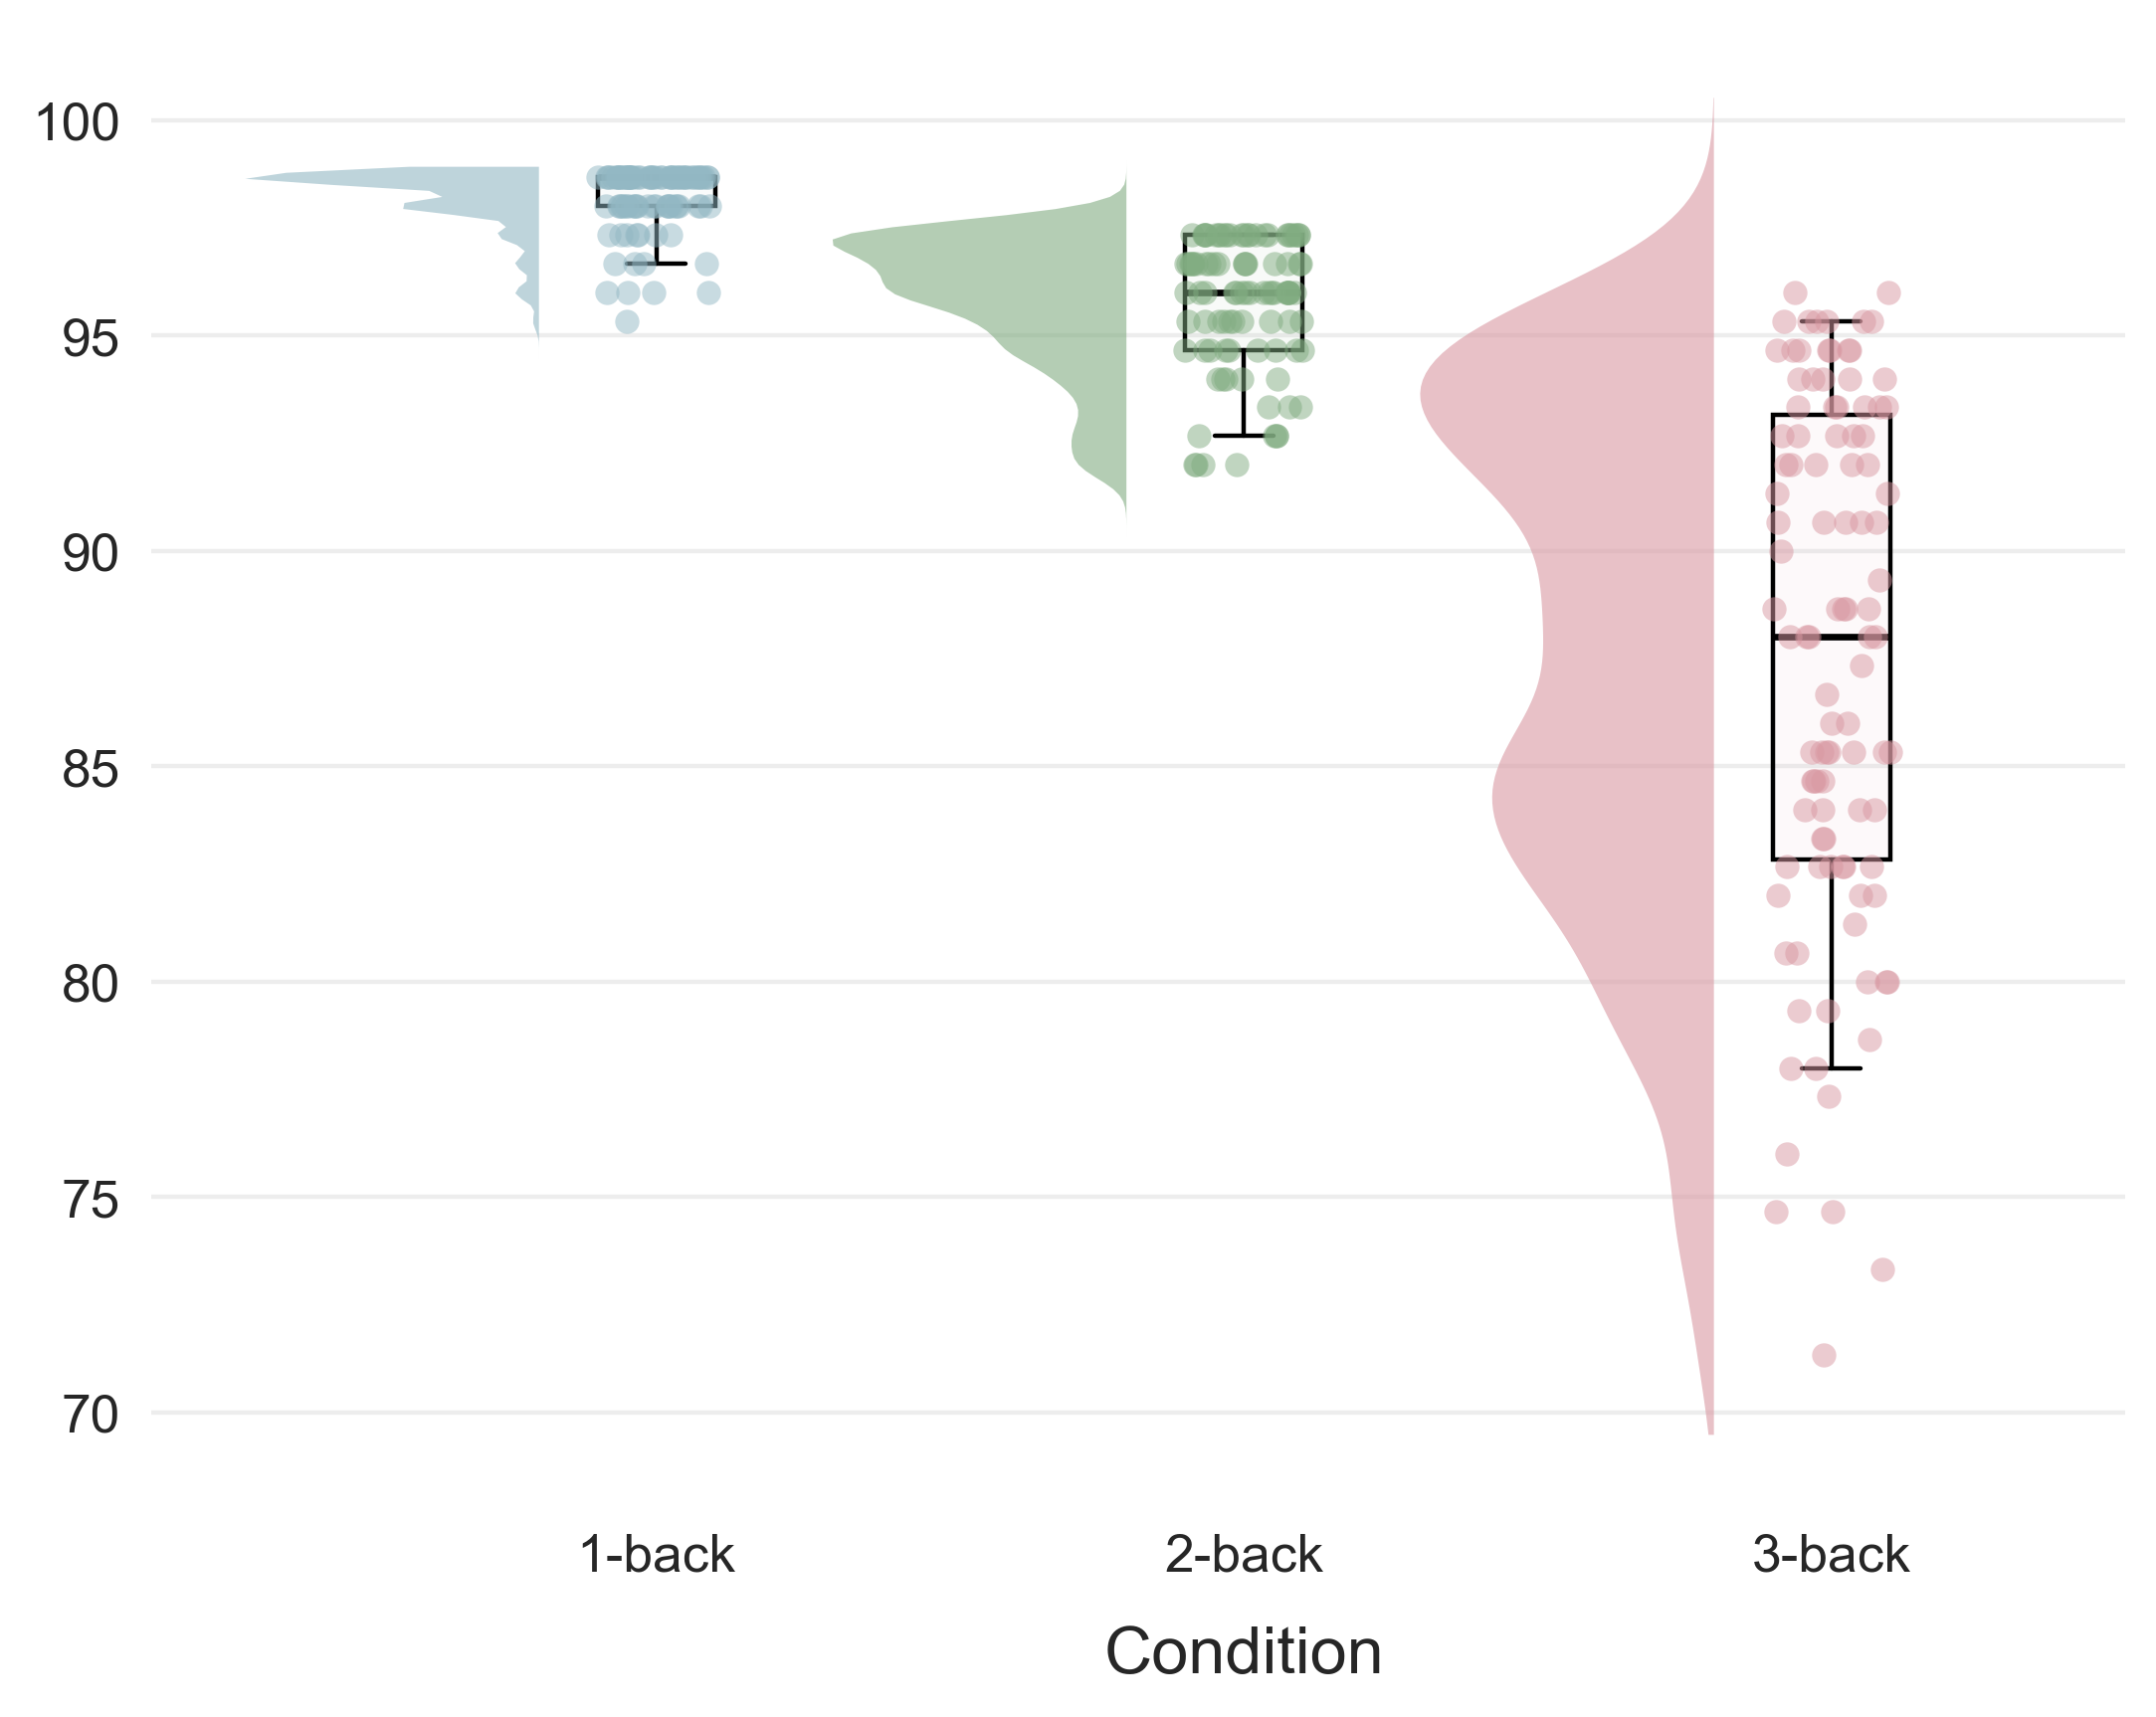

In [3]:
# Loop through variables
for var, ttl, ylab, sname in zip(variables, titles, y_labels, save_names):

    dvar = dat.loc[~dat[var].isna(), ["ID", "Condition", var]].copy()
    if dvar.empty:
        continue

    # enforce categorical order for plotting & stats
    dvar["Condition"] = pd.Categorical(dvar["Condition"], categories=condition_order, ordered=True)

    # y-limits
    lower_bound = dvar[var].min()
    upper_bound = dvar[var].max()

    # ======================
    # Mixed model + pairwise contrasts (Bonf)
    pw = mixedlm_pairwise_contrasts(
        dvar.rename(columns={var: "value"}),
        value_col="value",
        group_col="Condition",
        id_col="ID",
        p_adjust="bonferroni"
    )

    # Stats plot with brackets
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    fig.patch.set_alpha(1.0)
    ax.patch.set_alpha(1.0)
    ax.set_facecolor("white")

    # ======================
    # MANUAL RAINCLOUD
    # Raincloud aesthetics
    viol_alpha   = 0.60     # violin fill opacity
    dot_alpha    = 0.5      # raindrop opacity
    dot_size     = 30       # raindrop size
    box_width    = 0.20     # boxplot width
    cloud_offset = -0.20    # shift of violin relative to category centre
    max_violsw   = 0.4      # maximum half-violin horizontal extent
    bw_method    = 0.15     # kernel bandwidth passed to gaussian_kde (smoothing)

    if var == "Accuracy":
        cloud_offset = -0.20    # shift of violin relative to category centre
        max_violsw   = 0.5      # maximum half-violin horizontal extent
        bw_method    = 0.25     # kernel bandwidth passed to gaussian_kde (smoothing)

    # x coordinates per condition in the specified order
    xpos = {c: i for i, c in enumerate(condition_order)}

    # deterministic jitter RNG
    rng = np.random.default_rng(12345)

    for cond in condition_order:
        yvals = dvar.loc[dvar["Condition"] == cond, var].dropna().to_numpy()
        if yvals.size == 0:
            continue

        # VIOLIN
        try:
            kde = gaussian_kde(yvals, bw_method=bw_method)
            y_min = np.nanmin(yvals)
            y_max = np.nanmax(yvals)
            if not np.isfinite(y_min) or not np.isfinite(y_max) or y_min == y_max:
                y_grid = np.linspace(y_min - 1e-6, y_max + 1e-6, 50)
            else:
                pad = 0.075 * (y_max - y_min) if (y_max - y_min) > 0 else 1.0
                y_grid = np.linspace(lower_bound - pad, upper_bound + pad, 200)

            dens = kde(y_grid)
            scale = (max_violsw / np.nanmax(dens)) if np.nanmax(dens) > 0 else 0.0

            # left-sided half-violin
            x_left  = xpos[cond] + cloud_offset - dens * scale
            x_right = np.full_like(y_grid, xpos[cond] + cloud_offset)

            poly_x = np.concatenate([x_right, x_left[::-1]])
            poly_y = np.concatenate([y_grid,  y_grid[::-1]])
            ax.fill(poly_x, poly_y, facecolor=pal_dict[cond], edgecolor="none", alpha=viol_alpha)

        except Exception:
            ax.scatter([xpos[cond] + cloud_offset], [np.nanmean(yvals)], s=60,
                       facecolor=pal_dict[cond], edgecolor="none", alpha=viol_alpha)

        # DOTS
        x_jit = xpos[cond] + rng.uniform(-box_width/2, box_width/2, size=yvals.size) # jitter over boxplot width
        ax.scatter(x_jit, yvals, s=dot_size, alpha=dot_alpha, color=pal_dict[cond], linewidths=0, zorder=3)

        # BOXPLOT
        bp = ax.boxplot(
            [yvals],
            positions=[xpos[cond]],
            widths=box_width,
            vert=True,
            patch_artist=True,
            showfliers=False,
            whis=(5, 95),
            medianprops=dict(color="black", linewidth=1.5),
            boxprops=dict(linewidth=1.0, edgecolor="black"),
            whiskerprops=dict(linewidth=1.0, color="black"),
            capprops=dict(linewidth=1.0, color="black"),
            meanline=False,
            showmeans=False
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(mpl.colors.to_rgba(pal_dict[cond], 0.05))  # alpha 0.4
            patch.set_edgecolor("black")
        for elem in ["whiskers", "caps", "medians"]:
            for artist in bp[elem]:
                artist.set_color("black")

    # Remove legend
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    # Remove x and y lines around plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Thin horizontal y-grid only
    ax.yaxis.grid(True, linewidth=1, alpha=0.35)
    ax.xaxis.grid(False)

    # ======================
    # Labels and title
    ax.set_title("")
    ax.set_xticks(range(len(condition_order)))
    ax.set_xticklabels(condition_order)

    # Place the x-axis label below condition 2 tick
    ax.set_xlabel("")
    ax.annotate(
    "Condition",
    xy=(xpos[condition_order[1]], 0),     # x in data coords, y anchored at x-axis
    xycoords=("data", "axes fraction"),   # x uses data coords, y uses axis fraction
    xytext=(0, -28),                      # shift downward in points
    textcoords="offset points",
    ha="center", va="top"
    )

    # y-scaling for brackets
    ymin = lower_bound
    ymax_data = dvar[var].max()
    ymax_cap  = upper_bound if upper_bound is not None else ymax_data
    ymax      = max(ymax_data, ymax_cap)
    range_y     = ymax - ymin
    step      = 0.10 * range_y if range_y > 0 else 1.0
    head      = 0.02 * range_y if range_y > 0 else 0.2

    xcats = list(dvar["Condition"].cat.categories)

    y_positions = []
    start = ymax + 0.075 * range_y
    for i in range(len(comparisons)):
        y_positions.append(start + i * step)

    if len(y_positions):
        ax.set_ylim(ymin, y_positions[-1] + head)
    else:
        ax.set_ylim(ymin, ymax)

    # Compute midpoint of current y-limits
    ymin, ymax = ax.get_ylim()
    ymid = (ymin + ymax) / 2
    # Hide the default y-label to avoid duplicates
    ax.set_ylabel("")
    ax.yaxis.get_label().set_visible(False)
    # Draw a y-label at the data midpoint, with x in axes-fraction space
    ax.text(
        -0.12,                                 # x in axes fraction (to the left of ticks)
        ymid,                                  # y in *data* coords: exact midpoint
        ylab,
        transform=ax.get_yaxis_transform(which='grid'),  # x=axes, y=data
        rotation=90,
        ha='center',
        va='center'
    )

    # Significance labels from pairwise table
    labels = []
    for (g1, g2) in comparisons:
        row = pw.loc[(pw["group1"] == g1) & (pw["group2"] == g2)]
        labels.append("n.s." if row.empty else p_to_signif(float(row["p_adj"].iloc[0])))

    # Brackets with explicit mapping
    add_stat_brackets(
        ax=ax,
        xcats=condition_order,
        comparisons=comparisons,
        y_positions=y_positions,
        labels=labels,
        xmap=xpos
    )

    # Axis-specific ticks
    #variables  = ["Accuracy", "ReactionTime", "GazeDeviation", "MSRate", "Fixations", "Saccades", "AlphaPower", "IAF"]
    if var == "Accuracy":
        ax.set_yticks(np.arange(65, 101, 5))
    elif var == "ReactionTime":
        ax.set_yticks(np.arange(0.3, 1.31, 0.1))
    elif var == "GazeDeviation":
        ax.set_yticks(np.arange(0, 70, 10))
    elif var == "MSRate":
        ax.set_yticks(np.arange(0, 3.05, 0.5))
    elif var == "Fixations":
        ax.set_yticks(np.arange(0, 9, 1))
    elif var == "Saccades":
        ax.set_yticks(np.arange(0, 4.25, 1))
    elif var == "AlphaPower":
        ax.set_yticks(np.arange(0, 1, 0.1))
    elif var == "IAF":
        ax.set_yticks(np.arange(8, 14, 1))

    # ======================
    # Save
    fig.tight_layout()
    fig.savefig(
        os.path.join(output_dir, f"AOC_stats_rainclouds_{sname}_nback_stats.png"),
        dpi=300,
        transparent=False,
        facecolor=fig.get_facecolor(),
        edgecolor=fig.get_edgecolor() if hasattr(fig, "get_edgecolor") else "white"
    )